In [ ]:
import pandas as pd
import os
# add reading window size as part of code
wsize=80
%matplotlib inline
os.chdir('/Users/vinayswamy/NIH/eyesplice_predictor/')

In [ ]:
col_names=['seqid', 'wstart','wend','ID']+list(range(80))
df=pd.read_csv('data/cleaned/HM7FMBBXX_16424750_S70_bp_features.tsv', sep='\t', header=None, names=col_names)

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df['ID'].unique()

In [ ]:
#need to do 3 things - reverse the SL columns, remove low count exons, and make feature column
el=df[df['ID'].str.contains('EL')]
sl=df[df['ID'].str.contains('SL')]
rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
sl_rev=sl.loc[:,rev_idx]
sl_rev.columns=col_names
data=pd.concat([el, sl_rev]).assign(Y= lambda x: (~x['ID'].str.contains('ref')).astype(int))
data['Y'].value_counts()

In [7]:
#remove low count exons
keep=data.loc[:,list(range(80))].sum(axis=1) >= 80
data_exp=data[keep]
data_exp['Y'].value_counts()

1    27499
0    24043
Name: Y, dtype: int64

In [8]:
#balance data for now
bal=data_exp['Y'].value_counts().min()
data_comp=pd.concat([data_exp[data_exp['Y']==1].sample(bal, random_state=420024),data_exp[data_exp['Y']==0].sample(bal, random_state=420024)])

In [9]:
print(data_comp.shape)
data_comp['Y'].value_counts()

(48086, 85)


1    24043
0    24043
Name: Y, dtype: int64

In [10]:
# above wrapped into a function for multiple sample use.
def pre_process(path, cut_off):
    col_names=['seqid', 'wstart','wend','ID']+list(range(80))
    df=pd.read_csv(path, sep='\t', header=None, names=col_names)
    el=df[df['ID'].str.contains('EL')]
    sl=df[df['ID'].str.contains('SL')]
    rev_idx= ['seqid','wstart','wend','ID']+list(range(79,-1,-1))
    sl_rev=sl.loc[:,rev_idx]
    sl_rev.columns=col_names
    data=pd.concat([el, sl_rev]).assign(Y= lambda x: (~x['ID'].str.contains('ref')).astype(int))
    keep=data.loc[:,list(range(80))].sum(axis=1) >= cut_off
    data_exp=data[keep]
    bal=data_exp['Y'].value_counts().min()
    data_comp=pd.concat([data_exp[data_exp['Y']==1].sample(bal, random_state=420024), data_exp[data_exp['Y']== 0].sample(bal, random_state=420024)])
    return(data_comp)
    

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
x_cols=list(range(80))
X=data_comp.loc[:,x_cols]
Y=data_comp['Y']
pca=PCA(n_components=2)
pcmat=pca.fit_transform(X)
drX=pd.DataFrame(data=pcmat ,columns=['PC1', 'PC2']).assign(lab=Y)

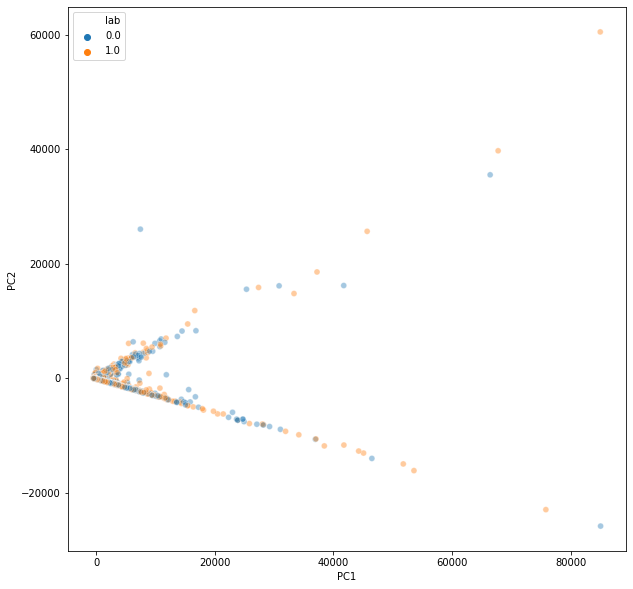

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='lab', alpha=.4)

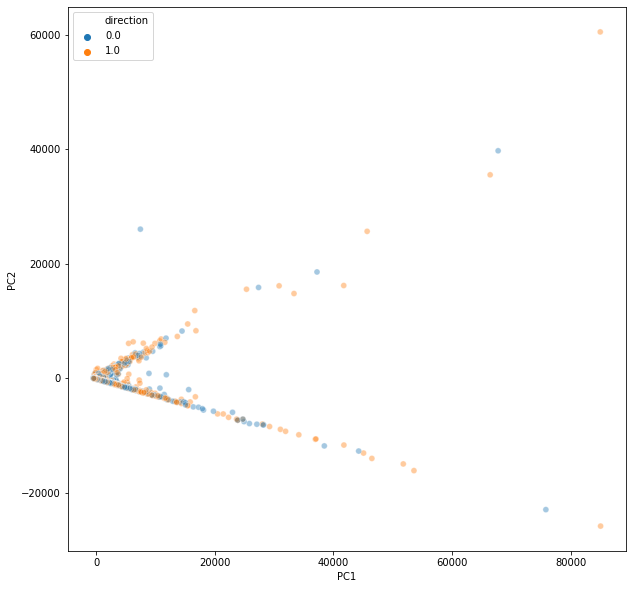

In [14]:
drX=drX.assign(direction=data_comp['ID'].str.contains('EL').astype(int))

plt.figure(figsize=(10,10))
sns.scatterplot(data=drX, x='PC1', y='PC2', hue='direction', alpha=.4)



In [15]:
pca.explained_variance_ratio_

array([0.84510364, 0.14251706])

PCA does not look that great,and I didn't boff the labels/ orientation, which leads me to ask, do we really need bp level info? may haps just the averages will work.

In [16]:
avg_df=(pd.DataFrame({'us_avg': data_comp.loc[:,list(range(40))].mean(axis=1),
                      'ds_avg': data_comp.loc[:,list(range(40,80))].mean(axis=1),
                      #'us_var': data_comp.loc[:,list(range(40))].var(axis=1),
                      #'ds_var': data_comp.loc[:,list(range(40,80))].var(axis=1),
                      'lab' : data_comp['Y']}))

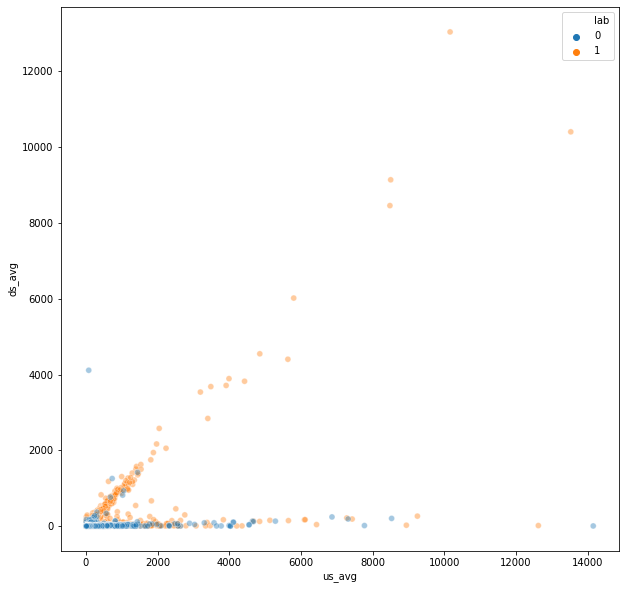

In [17]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=avg_df, x='us_avg', y='ds_avg', hue='lab', alpha=.4)

In [18]:
ls

README.md           config.yaml         notebooks/
Snakefile           data/               sampleTableESP.tsv
cluster.json        envs/               scripts/


In [19]:
avg_df['us_avg'].var()

62319.585598826925

In [20]:
avg_df['ds_avg'].var()

16055.424447989333

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix , roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

def ROC_plot(Y_test, Y_prob):
    fpr, tpr, thresholds=roc_curve(Y_test, Y_prob)
    auc=roc_auc_score(Y_test, Y_prob)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
def PR_plot(Y_test, Y_prob):
    pre, rec, thresholds = precision_recall_curve(Y_test, Y_prob)
    auc = average_precision_score(Y_test, Y_prob)
    plt.plot(rec, pre, label=' Prec/Rec (area = %0.2f)' % ( auc))
    plt.plot([1, 1], [1, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('')
    plt.legend(loc="lower right")
    plt.show()   

def train_model(X,Y, model):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=8976)
    model.fit(X_train, Y_train)
    Y_pred=model.predict(X_test)
    Y_prob=model.predict_proba(X_test)[:,1]
    print(confusion_matrix(y_pred=Y_pred,y_true=Y_test))
    print(classification_report(y_pred=Y_pred,y_true=Y_test))
    ROC_plot(Y_test , Y_prob)
    PR_plot(Y_test,Y_prob)

[[5385 1792]
 [2056 5193]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      7177
           1       0.74      0.72      0.73      7249

    accuracy                           0.73     14426
   macro avg       0.73      0.73      0.73     14426
weighted avg       0.73      0.73      0.73     14426



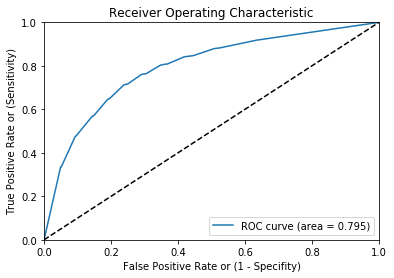

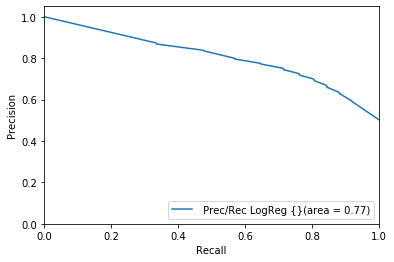

In [24]:
# now try the averaged windows 
Y_avg=avg_df['lab']
X_avg=avg_df.drop('lab',axis=1)
train_model(X_avg,Y_avg,model[0])

Random Forest


/Users/vinayswamy/anaconda3/envs/esp_pyenv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[5852 1325]
 [1872 5377]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      7177
           1       0.80      0.74      0.77      7249

    accuracy                           0.78     14426
   macro avg       0.78      0.78      0.78     14426
weighted avg       0.78      0.78      0.78     14426



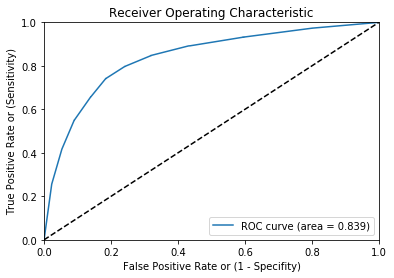

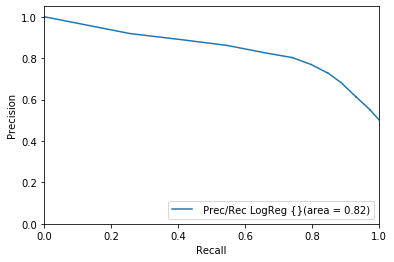

XGBC
[[5666 1511]
 [1520 5729]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      7177
           1       0.79      0.79      0.79      7249

    accuracy                           0.79     14426
   macro avg       0.79      0.79      0.79     14426
weighted avg       0.79      0.79      0.79     14426



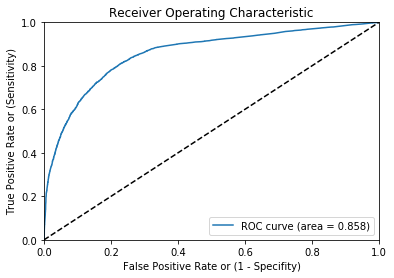

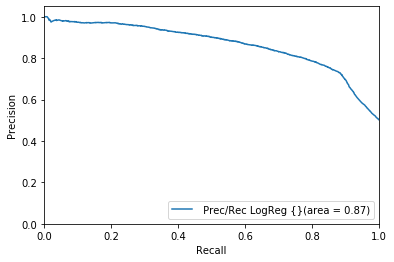

KNN
[[6191  986]
 [2828 4421]]
              precision    recall  f1-score   support

           0       0.69      0.86      0.76      7177
           1       0.82      0.61      0.70      7249

    accuracy                           0.74     14426
   macro avg       0.75      0.74      0.73     14426
weighted avg       0.75      0.74      0.73     14426



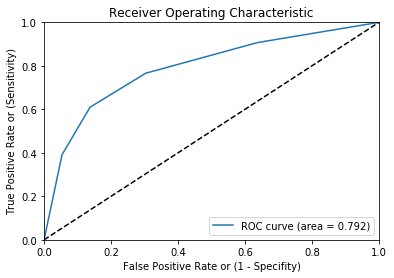

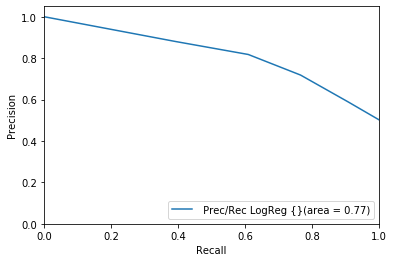

In [28]:
model=[RandomForestClassifier(random_state=3323), XGBClassifier(random_state=2234), KNeighborsClassifier(n_neighbors=4)]
model_names=['Random Forest', 'XGBC', 'KNN']
for m,n in  zip(model, model_names) :
    print(n)
    train_model(X,Y,m)

Random Forest
[[5385 1792]
 [2056 5193]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      7177
           1       0.74      0.72      0.73      7249

    accuracy                           0.73     14426
   macro avg       0.73      0.73      0.73     14426
weighted avg       0.73      0.73      0.73     14426



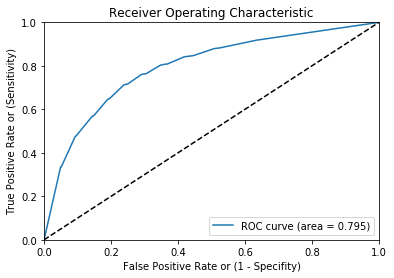

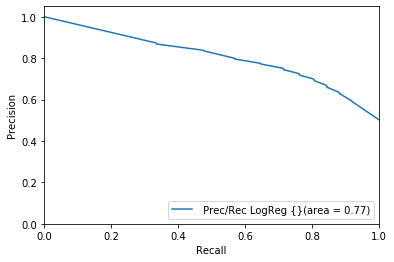

XGBC
[[5798 1379]
 [1918 5331]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      7177
           1       0.79      0.74      0.76      7249

    accuracy                           0.77     14426
   macro avg       0.77      0.77      0.77     14426
weighted avg       0.77      0.77      0.77     14426



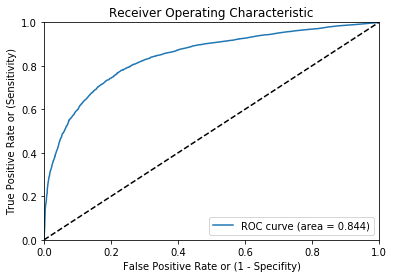

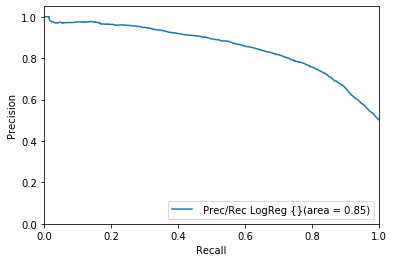

KNN
[[6033 1144]
 [2632 4617]]
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      7177
           1       0.80      0.64      0.71      7249

    accuracy                           0.74     14426
   macro avg       0.75      0.74      0.74     14426
weighted avg       0.75      0.74      0.74     14426



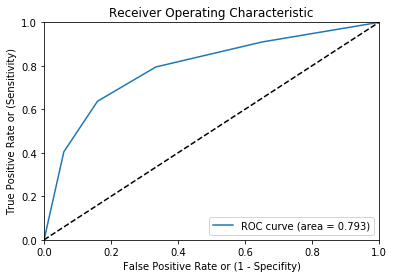

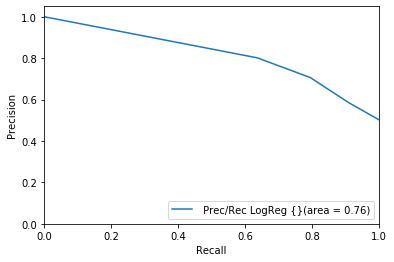

In [29]:
Y_avg=avg_df['lab']
X_avg=avg_df.drop('lab',axis=1)
for m,n in  zip(model, model_names) :
    print(n)
    train_model(X_avg,Y_avg,m)
